In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_validate
import os

os.chdir('/Users/mabourqu/Documents/PhD/CryoBiome/')

This code was used for a grid search of the best C parameter (penalisation of coefficients), assessing the mean Accuracy for both PP1 and PP2. - It included these values: [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]
- The best (and kept) C parameter value was 0.03 (balanced accuracy > 0.968)

# PP1

In [2]:
PP1_metadata = pd.read_csv('Metadata/PP1_metadata.tsv', sep='\t')
PP1_pres_abs = pd.read_csv('Data/trees/PP1_005_ASVs_table.csv')
PP1_pres_abs = PP1_pres_abs[PP1_metadata['Sample'].to_list()]
PP1_t = PP1_pres_abs.to_numpy()
PP1_t = PP1_t.transpose()
PP1_labels = np.array([1 if PP1_metadata[PP1_metadata['Sample'] == i]['Cryosphere'].values == 'Yes' else 0 for i in PP1_pres_abs.columns.to_list()])
print(PP1_t.shape)
print(PP1_labels.shape)

def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    return([imp,names])

PP1_features_names = pd.read_csv('Data/trees/PP1_005_ASVs_table.csv',header = 0,usecols = [0])['ASV']
PP1_features_taxa = pd.read_csv('Data/trees/PP1_005_ASVs_table.csv',header = 0,usecols = [1])['Taxonomy']
print(PP1_features_names[1:3])
print(PP1_features_taxa[1:3])

(2508, 19353)
(2508,)
1    00038cf8efa9dce3ce68504e32337c18
2    0005af3e39f85478242c0e9a8def72cd
Name: ASV, dtype: object
1    d__Bacteria; p__Actinobacteriota; c__Actinobac...
2    d__Bacteria; p__Actinobacteriota; c__Actinobac...
Name: Taxonomy, dtype: object


0


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

1


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

2


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

3


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

4


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

5


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

6


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

7


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

8


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

9


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

10


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

11


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

12


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

13


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

14


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

15


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

16


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

17


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

18


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

19


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

20


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

21


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

22


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

23


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

24


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

25


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

26


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

27


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

28


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

29


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

30


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

31


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

32


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

33


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

34


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

35


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

36


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

37


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

38


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

39


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

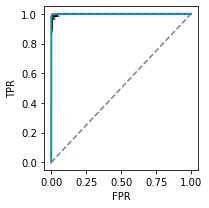

AUC: 0.99930005005005 0.000271732328287876
Balanced accuracy: 0.9603677339157605 0.019305400623204603
Precision: 0.9998892287399519 0.0005104838187990052
Recall: 0.920837431693989 0.03860269451029898


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

classifier = LogisticRegression(solver = 'lbfgs',
                                random_state=23,
                                max_iter=1000,
                                penalty='none',
                                class_weight='balanced')

PP1_tprs = []
PP1_aucs = []
PP1_mean_fpr = np.linspace(0, 1, 1000)
PP1_feature_imp_list = []
PP1_bal_acc = []
PP1_precision = []
PP1_recall = []

fig, ax = plt.subplots(figsize=(3,3))
for iteration in range(0,40):
    print(iteration)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = iteration)
    for i, (train, test) in enumerate(cv.split(PP1_t, PP1_labels)):

        classifier.fit(PP1_t[train], PP1_labels[train])
        
        # AUC curves
        viz = plot_roc_curve(classifier, PP1_t[test], PP1_labels[test],
                             sample_weight=np.array([1/(np.sum(PP1_labels[test] == 1)) if l == 1 else 1/(np.sum(PP1_labels[test] == 0)) for l in PP1_labels[test]]),
                             alpha=0.2, lw=1, ax=ax, color='black')
        
        interp_tpr = np.interp(PP1_mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        PP1_tprs.append(interp_tpr)
        PP1_aucs.append(viz.roc_auc)
        
        # Other metrics
        predictions = classifier.predict(PP1_t[test])
        PP1_bal_acc.append(accuracy_score(PP1_labels[test], predictions, sample_weight=np.array([1/(np.sum(PP1_labels[test] == 1)) if l == 1 else 1/(np.sum(PP1_labels[test] == 0)) for l in PP1_labels[test]])))
        PP1_precision.append(precision_score(PP1_labels[test], predictions, sample_weight=np.array([1/(np.sum(PP1_labels[test] == 1)) if l == 1 else 1/(np.sum(PP1_labels[test] == 0)) for l in PP1_labels[test]])))
        PP1_recall.append(recall_score(PP1_labels[test], predictions, sample_weight=np.array([1/(np.sum(PP1_labels[test] == 1)) if l == 1 else 1/(np.sum(PP1_labels[test] == 0)) for l in PP1_labels[test]])))
        
        # Storing SVM coefficients
        feat_imp = f_importances(classifier.coef_, PP1_features_names)
        PP1_feature_imp_list.append(feat_imp)
        
ax.get_legend().remove()
PP1_mean_tpr = np.mean(PP1_tprs, axis=0)
PP1_mean_tpr[-1] = 1.0
PP1_mean_auc = metrics.auc(PP1_mean_fpr, PP1_mean_tpr)
PP1_std_auc = np.std(PP1_aucs)

plt.hlines(y=1,xmin=0,xmax=1,linestyle='dashed',color='darkgrey')
ax.plot(PP1_mean_fpr, PP1_mean_tpr, color='#1A87BD',lw=2)
ax.set_ylim(-0.05,1.05)
ax.set_xlim(-0.05,1.05)
ax.plot([0,1],[0,1],'--',c='grey')
plt.ylabel('TPR')
plt.xlabel('FPR')

plt.tight_layout()
plt.savefig('1_ASV_analysis/1_1_Logistic_classifier/1_1_PP1_Logistic_roc.pdf')
plt.show()

PP1_feature_importance = np.exp(np.array([np.array(i[0]) for i in PP1_feature_imp_list]))
PP1_feature_importance_means = np.mean(PP1_feature_importance, axis=0)

PP1_importance_df = pd.DataFrame({'ASV':PP1_features_names,'Taxonomy':PP1_features_taxa,'Importance':PP1_feature_importance_means[0]})
PP1_importance_df.to_csv('Data/PP1_Logistics_coefs.csv',sep=',',index=False)

print('AUC:', PP1_mean_auc, PP1_std_auc)
print('Balanced accuracy:', np.mean(PP1_bal_acc), np.std(PP1_bal_acc))
print('Precision:', np.mean(PP1_precision), np.std(PP1_precision))
print('Recall:', np.mean(PP1_recall), np.std(PP1_recall))

# PP2

In [4]:
PP2_metadata = pd.read_csv('Metadata/PP2_metadata.tsv', sep='\t')
PP2_pres_abs = pd.read_csv('Data/trees/PP2_005_ASVs_table.csv')
PP2_pres_abs = PP2_pres_abs[PP2_metadata['Sample'].to_list()]
PP2_t = PP2_pres_abs.to_numpy()
PP2_t = PP2_t.transpose()
PP2_labels = np.array([1 if PP2_metadata[PP2_metadata['Sample'] == i]['Cryosphere'].values == 'Yes' else 0 for i in PP2_pres_abs.columns.to_list()])
print(PP2_t.shape)
print(PP2_labels.shape)

PP2_features_names = pd.read_csv('Data/trees/PP2_005_ASVs_table.csv',header = 0,usecols = [0])['ASV']
PP2_features_taxa = pd.read_csv('Data/trees/PP2_005_ASVs_table.csv',header = 0,usecols = [1])['Taxonomy']
print(PP2_features_names[1:3])
print(PP2_features_taxa[1:3])

(1739, 18296)
(1739,)
1    0003e5f611e467172b41ea746dbe7cce
2    000aab9b27c9d93615f5fb6ac9985d07
Name: ASV, dtype: object
1    d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...
2    d__Bacteria; p__Actinobacteriota; c__Actinobac...
Name: Taxonomy, dtype: object


0


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

1


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

2


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

3


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

4


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

5


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

6


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

7


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

8


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

9


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

10


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

11


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

12


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

13


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

14


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

15


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

16


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

17


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

18


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

19


/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mabourqu/opt/anaconda3/envs/GFSDM_projections/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureW

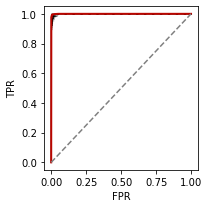

AUC: 0.9993260219954763 0.00028260170491449494
Balanced accuracy: 0.9795006328510633 0.013529576404119127
Precision: 0.9993448294054578 0.0014478572872638265
Recall: 0.95963323596235 0.02705691665410862


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

classifier = LogisticRegression(solver = 'lbfgs',
                                random_state=23,
                                max_iter=1000,
                                penalty='none',
                                class_weight='balanced')

PP2_tprs = []
PP2_aucs = []
PP2_mean_fpr = np.linspace(0, 1, 1000)
PP2_feature_imp_list = []
PP2_bal_acc = []
PP2_precision = []
PP2_recall = []

fig, ax = plt.subplots(figsize=(3,3))
for iteration in range(0,20):
    print(iteration)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = iteration)
    for i, (train, test) in enumerate(cv.split(PP2_t, PP2_labels)):

        classifier.fit(PP2_t[train], PP2_labels[train])
        
        # AUC curves
        viz = plot_roc_curve(classifier, PP2_t[test], PP2_labels[test],
                             sample_weight=np.array([1/(np.sum(PP2_labels[test] == 1)) if l == 1 else 1/(np.sum(PP2_labels[test] == 0)) for l in PP2_labels[test]]),
                             alpha=0.2, lw=1, ax=ax, color='black')
        
        interp_tpr = np.interp(PP2_mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        PP2_tprs.append(interp_tpr)
        PP2_aucs.append(viz.roc_auc)
        
        # Other metrics
        predictions = classifier.predict(PP2_t[test])
        PP2_bal_acc.append(accuracy_score(PP2_labels[test], predictions, sample_weight=np.array([1/(np.sum(PP2_labels[test] == 1)) if l == 1 else 1/(np.sum(PP2_labels[test] == 0)) for l in PP2_labels[test]])))
        PP2_precision.append(precision_score(PP2_labels[test], predictions, sample_weight=np.array([1/(np.sum(PP2_labels[test] == 1)) if l == 1 else 1/(np.sum(PP2_labels[test] == 0)) for l in PP2_labels[test]])))
        PP2_recall.append(recall_score(PP2_labels[test], predictions, sample_weight=np.array([1/(np.sum(PP2_labels[test] == 1)) if l == 1 else 1/(np.sum(PP2_labels[test] == 0)) for l in PP2_labels[test]])))
        
        # Storing SVM coefficients
        feat_imp = f_importances(classifier.coef_, PP2_features_names)
        PP2_feature_imp_list.append(feat_imp)
        
ax.get_legend().remove()
PP2_mean_tpr = np.mean(PP2_tprs, axis=0)
PP2_mean_tpr[-1] = 1.0
PP2_mean_auc = metrics.auc(PP2_mean_fpr, PP2_mean_tpr)
PP2_std_auc = np.std(PP2_aucs)

plt.hlines(y=1,xmin=0,xmax=1,linestyle='dashed',color='darkgrey')
ax.plot(PP2_mean_fpr, PP2_mean_tpr, color='#BA0600',lw=2)
ax.set_ylim(-0.05,1.05)
ax.set_xlim(-0.05,1.05)
ax.plot([0,1],[0,1],'--',c='grey')
plt.ylabel('TPR')
plt.xlabel('FPR')

plt.tight_layout()
plt.savefig('1_ASV_analysis/1_1_Logistic_classifier/1_1_PP2_Logistic_roc.pdf')
plt.show()

PP2_feature_importance = np.exp(np.array([np.array(i[0]) for i in PP2_feature_imp_list]))
PP2_feature_importance_means = np.mean(PP2_feature_importance, axis=0)

PP2_importance_df = pd.DataFrame({'ASV':PP2_features_names,'Taxonomy':PP2_features_taxa,'Importance':PP2_feature_importance_means[0]})
PP2_importance_df.to_csv('Data/PP2_Logistic_coefs.csv',sep=',',index=False)

print('AUC:', PP2_mean_auc, PP2_std_auc)
print('Balanced accuracy:', np.mean(PP2_bal_acc), np.std(PP2_bal_acc))
print('Precision:', np.mean(PP2_precision), np.std(PP2_precision))
print('Recall:', np.mean(PP2_recall), np.std(PP2_recall))